<a href="https://colab.research.google.com/github/spanman888/DSC672_Teacher_Salary/blob/master/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install catboost
import pandas as pd
import os
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import sys
import csv
from operator import itemgetter
import copy

from sklearn.model_selection import cross_validate, train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale
from catboost import CatBoostRegressor, Pool

pd.set_option('display.max_columns', 100)

     |████████████████████████████████| 61.1MB 529kB/s 


In [0]:
# In order to download files to local file system
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
#Download  dataframe
#This is with specific redundant columns removed as well as outliers per previous analysis
df_cat = pd.read_csv('drive/My Drive/df_cat.csv', index_col=0)
df_cat.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,AdjSalMonth,sch_num,gender,emply_desc,months_employed,fte,dist_exp,state_exp,out_of_state_exp,pos_cd,low_grade,high_grade,pct_admin,first_3,Zip_Type,multi_assign_2,multi_assign_3,eth_groups,edu_groups,grade_taught,loc_taught,assign1_groups
0,4029.489540,1003,F,Full-Time,9,100,1.0,1.0,0.0,20,00,07,0.0,601,Suburb,0,0,White,Bachelors,7,OneSch_Taught,3
1,12889.019160,1005,F,Full-Time,9,100,23.0,27.0,1.0,20,07,08,0.0,600,Suburb,0,0,White,Masters,8,OneSch_Taught,6
3,8668.664381,1003,F,Full-Time,9,100,12.0,12.0,0.0,20,07,08,0.0,601,Suburb,0,0,White,Masters,8,OneSch_Taught,6
4,10681.660375,2,F,Full-Time,10,100,5.0,5.0,8.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,1
5,8012.189620,2002,F,Full-Time,10,100,1.0,2.0,9.0,19,01,05,0.0,600,Suburb,0,0,White,Doctorate,5,OneSch_Taught,4
6,7298.253984,2002,F,Full-Time,9,100,9.0,9.0,0.0,20,00,06,0.0,600,Suburb,0,0,White,Masters,6,OneSch_Taught,6
7,8576.624386,30,F,Full-Time,9,100,8.0,8.0,0.0,22,09,12,0.0,606,Chicago,0,0,White,Bachelors,12,OneSch_Taught,4
8,7031.448365,1017,M,Full-Time,10,100,3.0,3.0,0.0,20,00,06,0.0,601,Suburb,1,1,White,Masters,6,OneSch_Taught,1
9,7751.625187,13,M,Full-Time,9,100,2.0,2.0,0.0,22,09,12,0.0,605,Suburb,0,0,White,Masters,12,OneSch_Taught,3
10,6745.656485,1,F,Full-Time,10,100,3.0,3.0,0.0,22,09,12,0.0,602,Other,0,0,White,Masters,12,OneSch_Taught,2


In [0]:
df_cat.shape

(1301569, 22)

In [0]:
df_cat['eth_groups'].value_counts()

White                               1108077
Black                                107617
Hispanic                              60851
Asian or Pacific Islander             15934
Unknown                                6883
American Indian or Alaska Native       2207
Name: eth_groups, dtype: int64

In [0]:
### CatBOOST ###

### TEST TRAIN VALIDATION SPLIT ###

num_instances = df_cat.shape[0]

Y = df_cat['AdjSalMonth']
X = df_cat.drop(['AdjSalMonth'], axis=1)

# Creating the train/test split
Y_train_cat, Y_test_cat, X_train_cat, X_test_cat = train_test_split(Y, X, test_size=0.3, random_state=33)  

# Splitting df_train into the train and then holding some out for validation
Y_train_cat, Y_val_cat, X_train_cat, X_val_cat = train_test_split(Y_train_cat, X_train_cat, test_size=0.143, random_state=33)

print("Confirming Splits...")
print("Y_TRAIN_Cat: " + str(Y_train_cat.shape[0]) + " = " + str(round((Y_train_cat.shape[0]/num_instances)*100, 2)) + "%")
print("Y_TEST_cat: " + str(Y_test_cat.shape[0]) + " = " + str(round((Y_test_cat.shape[0]/num_instances)*100, 2)) + "%")
print("Y_VALIDATION_cat: " + str(Y_val_cat.shape[0]) + " = " + str(round((Y_val_cat.shape[0]/num_instances)*100, 2)) + "%")

print()
print("X_TRAIN_cat: " + str(X_train_cat.shape[0]) +  ", " + str(X_train_cat.shape[1]) + " = " + str(round((X_train_cat.shape[0]/num_instances)*100, 2)) + "%")
print("X_TEST_cat: " + str(X_test_cat.shape[0]) +  ", " + str(X_test_cat.shape[1]) + " = " + str(round((X_test_cat.shape[0]/num_instances)*100, 2)) + "%")
print("X_VALIDATION_cat: " + str(X_val_cat.shape[0]) +  ", " + str(X_val_cat.shape[1]) + " = " + str(round((X_val_cat.shape[0]/num_instances)*100, 2)) + "%")

# This is a *close* Train/Test/Validation split of 60/30/10

Confirming Splits...
Y_TRAIN_Cat: 780810 = 59.99%
Y_TEST_cat: 390471 = 30.0%
Y_VALIDATION_cat: 130288 = 10.01%

X_TRAIN_cat: 780810, 21 = 59.99%
X_TEST_cat: 390471, 21 = 30.0%
X_VALIDATION_cat: 130288, 21 = 10.01%


In [0]:
from catboost import CatBoostRegressor, Pool

start_ts=time.time()
print("CatBoost Results\n")
model=CatBoostRegressor(n_estimators=250, random_seed=44, logging_level='Silent')
model.fit(X_train_cat, Y_train_cat, cat_features=([0, 1, 2, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20]), 
          eval_set=(X_test_cat, Y_test_cat))

RMSE_train = math.sqrt(metrics.mean_squared_error(Y_train_cat, model.predict(X_train_cat)))
print('CatBoost Train RMSE:', RMSE_train)
RMSE_test = math.sqrt(metrics.mean_squared_error(Y_test_cat, model.predict(X_test_cat)))
print('CatBoost Test RMSE:', RMSE_test)
print()
EV_train = metrics.explained_variance_score(Y_train_cat, model.predict(X_train_cat))
print('CatBoost Train Explained Variance:', EV_train) 
EV_test = metrics.explained_variance_score(Y_test_cat, model.predict(X_test_cat))
print('CatBoost Test Explained Variance:', EV_test)
print("CV Runtime:", time.time()-start_ts)

CatBoost Results



KeyboardInterrupt: ignored

In [0]:
important_features_dict = {}
features = X_train_cat.columns.tolist()
for x,i in enumerate(model.feature_importances_):
    important_features_dict[x]=i

# the index of the most important features in decreasing order
lst = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print('Most important features:')
for i in lst:
  print(features[i])

In [0]:
# top 9 features
X_train_cat_fs = X_train_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc', 'low_grade', 'fte']]
X_test_cat_fs = X_test_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc', 'low_grade', 'fte']]

In [0]:
# top 9 features
from catboost import CatBoostRegressor
start_ts=time.time()
print("CatBoost Results\n")
model=CatBoostRegressor(n_estimators=250, random_seed=44, logging_level='Silent')
model.fit(X_train_cat_fs, Y_train_cat, cat_features=([2, 4, 5, 6, 7]), 
          eval_set=(X_test_cat_fs, Y_test_cat))

RMSE_train9 = math.sqrt(metrics.mean_squared_error(Y_train_cat, model.predict(X_train_cat_fs)))
print('CatBoost Train RMSE:', RMSE_train9)
RMSE_test9 = math.sqrt(metrics.mean_squared_error(Y_test_cat, model.predict(X_test_cat_fs)))
print('CatBoost Test RMSE:', RMSE_test9)
print()
EV_train9 = metrics.explained_variance_score(Y_train_cat, model.predict(X_train_cat_fs))
print('CatBoost Train Explained Variance:', EV_train9) 
EV_test9 = metrics.explained_variance_score(Y_test_cat, model.predict(X_test_cat_fs))
print('CatBoost Test Explained Variance:', EV_test9)
print("CV Runtime:", time.time()-start_ts)

In [0]:
# top 8 features
X_train_cat_fs = X_train_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc', 'low_grade']]
X_test_cat_fs = X_test_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc', 'low_grade']]

In [0]:
#validation - top 8
X_val_cat_fs = X_val_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc', 'low_grade']]

In [0]:
# top 8 features
from catboost import CatBoostRegressor
start_ts=time.time()
print("CatBoost Results\n")
model=CatBoostRegressor(n_estimators=250, random_seed=44, logging_level='Silent')
model.fit(X_train_cat_fs, Y_train_cat, cat_features=([2, 4, 5, 6, 7]), 
          eval_set=(X_test_cat_fs, Y_test_cat))

RMSE_train8 = math.sqrt(metrics.mean_squared_error(Y_train_cat, model.predict(X_train_cat_fs)))
print('CatBoost Train RMSE:', RMSE_train8)
RMSE_test8 = math.sqrt(metrics.mean_squared_error(Y_test_cat, model.predict(X_test_cat_fs)))
print('CatBoost Test RMSE:', RMSE_test8)
print()
EV_train8 = metrics.explained_variance_score(Y_train_cat, model.predict(X_train_cat_fs))
print('CatBoost Train Explained Variance:', EV_train8) 
EV_test8 = metrics.explained_variance_score(Y_test_cat, model.predict(X_test_cat_fs))
print('CatBoost Test Explained Variance:', EV_test8)
print("CV Runtime:", time.time()-start_ts)

In [0]:
# Compute the correlation matrix
corr = X_train_cat_fs.corr()
corr

In [0]:
#prediction plot for final CatBoost model - test data

pred_test = model.predict(X_test_cat_fs)

fig,ax = plt.subplots()
ax.scatter(Y_test_cat, pred_test)
ax.plot([Y_test_cat.min(), Y_test_cat.max()], [Y_test_cat.min(), Y_test_cat.max()], 'k--', lw=4)
ax.set_xlabel('Actual', fontsize=16)
ax.set_ylabel('Predicted', fontsize=16)
ax.set_title('Predicted vs Actual - test data set', fontsize=20)
fig.show()


In [0]:
#prediction plot for final CatBoost model - validation data
from yellowbrick.regressor import PredictionError

pred_val = model.predict(X_val_cat_fs)

fig,ax = plt.subplots()
ax.scatter(Y_val_cat, pred_val)
ax.plot([Y_val_cat.min(), Y_val_cat.max()], [Y_val_cat.min(), Y_val_cat.max()], 'k--', lw=4)
ax.set_xlabel('Actual', fontsize=16)
ax.set_ylabel('Predicted', fontsize=16)
ax.set_title('Predicted vs Actual - validation data set', fontsize=20)
fig.show()


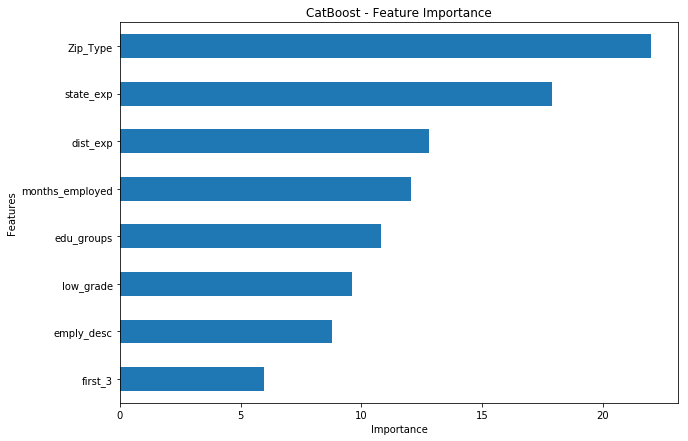

In [0]:
#Graph of relative feature importance to model
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train_cat_fs.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [0]:
# top 7 features
X_train_cat_fs = X_train_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc']]
X_test_cat_fs = X_test_cat[['state_exp', 'dist_exp', 'Zip_Type', 'months_employed', 'edu_groups', 'first_3',
                              'emply_desc']]

In [0]:
# top 7 features
from catboost import CatBoostRegressor
start_ts=time.time()
print("CatBoost Results\n")
model=CatBoostRegressor(n_estimators=250, random_seed=44, logging_level='Silent')
model.fit(X_train_cat_fs, Y_train_cat, cat_features=([2, 4, 5, 6]), 
          eval_set=(X_test_cat_fs, Y_test_cat))

RMSE_train7 = math.sqrt(metrics.mean_squared_error(Y_train_cat, model.predict(X_train_cat_fs)))
print('CatBoost Train RMSE:', RMSE_train7)
RMSE_test7 = math.sqrt(metrics.mean_squared_error(Y_test_cat, model.predict(X_test_cat_fs)))
print('CatBoost Test RMSE:', RMSE_test7)
print()
EV_train7 = metrics.explained_variance_score(Y_train_cat, model.predict(X_train_cat_fs))
print('CatBoost Train Explained Variance:', EV_train7) 
EV_test7 = metrics.explained_variance_score(Y_test_cat, model.predict(X_test_cat_fs))
print('CatBoost Test Explained Variance:', EV_test7)
print("CV Runtime:", time.time()-start_ts)

CatBoost Results

CatBoost Train RMSE: 1458.679534306574
CatBoost Test RMSE: 1468.6509805750684

CatBoost Train Explained Variance: 0.6958779269707669
CatBoost Test Explained Variance: 0.6868341397402027
CV Runtime: 239.46118712425232


In [0]:
num_vars = ['All', '9', '8', '7']
RMSE_Test_lst = [RMSE_test, RMSE_test9, RMSE_test8, RMSE_test7]
RMSE_Train_lst = [RMSE_train, RMSE_train9, RMSE_train8, RMSE_train7]
EV_Test_lst = [EV_test,EV_test9,EV_test8,EV_test7]
EV_Train_lst = [EV_train,EV_train9,EV_train8,EV_train7]

In [0]:
import matplotlib.pyplot as plt
plt.close('all')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

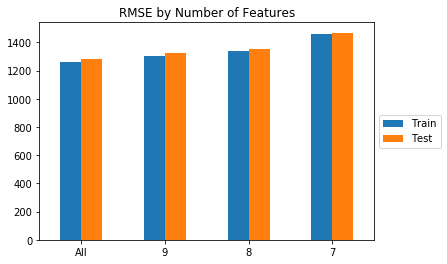

In [0]:
df = pd.DataFrame({'Train': RMSE_Train_lst,'Test': RMSE_Test_lst}, index=num_vars)
ax = df.plot.bar()
plt.title('RMSE by Number of Features')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

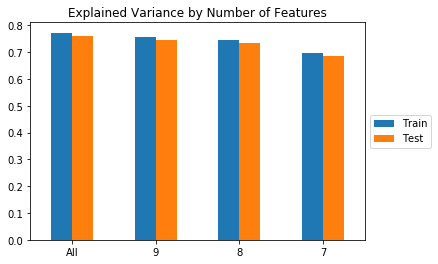

In [0]:
df = pd.DataFrame({'Train': EV_Train_lst,'Test': EV_Test_lst}, index=num_vars)
ax = df.plot.bar()
plt.title('Explained Variance by Number of Features')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)